# This is The Title of Notebook
### Purpose
This notebook will look at comparing the usability of temperature readings between Christmas Bird Count Volunteers and NOAA Weather Stations.

### Author: 
Jacob Ellena
### Date: 
2020-07-30
### Update Date: 
2020-07-30

### Inputs 
1.3-rec-connecting-fips-ecosystem-data.txt -  
Example
cbc_effort_weather_1900-2018.txt - Tab seperated file of Christmas Bird Count events going back to 1900. Each row represents a single count in a given year. Data Dictonary can be found here: http://www.audubon.org/sites/default/files/documents/cbc_report_field_definitions_2013.pdf

### Output Files
None

## Steps or Proceedures in the notebook 
Comparisons are split into the following sections
- Data Import and Formatting
- User Variables
- Distance, Elevation, and Ecosystem Checks
- Missing Data 
- Out of Bounds Data
- Temperatures 


## Where the Data will Be Saved 
All data for this project will be saved in Google Drive. To start experimenting with data, download the folder hear and put it into your data folder.
https://drive.google.com/drive/folders/1Nlj9Nq-_dPFTDbrSDf94XMritWYG6E2I

The path should look like this: 
audubon-cbc/data/Cloud_Data/<DATA FILE>

---

## Importing and Formatting

In [21]:
# Imports 
import pandas as pd
import numpy as np
import math
from sklearn.metrics.pairwise import haversine_distances
from sklearn.neighbors import DistanceMetric
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#Options
pd.set_option("display.max_columns", 100)

In [22]:
# ALL File Paths should be declared at the TOP of the notebook
PATH_TO_RAW_CBC_DATA = "../data/Cloud_Data/1.3-rec-connecting-fips-ecosystem-data.txt"

In [23]:
raw_data = pd.read_csv(PATH_TO_RAW_CBC_DATA, encoding = "ISO-8859-1", sep="\t", compression='gzip')

C:\Users\jacob\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (62,64,65,71,73,75,77) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [58]:
list(raw_data.columns)

['circle_name',
 'country_state',
 'lat',
 'lon',
 'count_year',
 'count_date',
 'n_field_counters',
 'n_feeder_counters',
 'min_field_parties',
 'max_field_parties',
 'field_hours',
 'feeder_hours',
 'nocturnal_hours',
 'field_distance',
 'nocturnal_distance',
 'distance_units',
 'min_temp',
 'max_temp',
 'temp_unit',
 'min_wind',
 'max_wind',
 'wind_unit',
 'min_snow',
 'max_snow',
 'snow_unit',
 'am_cloud',
 'pm_cloud',
 'field_distance_imperial',
 'field_distance_metric',
 'nocturnal_distance_imperial',
 'nocturnal_distance_metric',
 'min_snow_imperial',
 'min_snow_metric',
 'max_snow_metric',
 'max_snow_imperial',
 'min_temp_imperial',
 'max_temp_imperial',
 'min_temp_metric',
 'max_temp_metric',
 'min_wind_metric',
 'max_wind_metric',
 'min_wind_imperial',
 'max_wind_imperial',
 'ui',
 'geohash_circle',
 'circle_id',
 'id',
 'latitude',
 'longitude',
 'elevation',
 'state',
 'name',
 'gsn_flag',
 'hcn_crn_flag',
 'wmoid',
 'geohash_station',
 'temp_min_value',
 'temp_max_value',


In [25]:
# Pulling out temperature data and renaming columns for clarification
temp_df_raw = raw_data[['count_year',
                    'circle_name', 
                    'circle_id',
                    'Ecosys_circle',
                    'circle_elev',
                    'lat',
                    'lon',
                    'min_temp',
                    'max_temp',
                    'id',
                    'Ecosys_station',
                    'elevation',
                    'latitude',
                    'longitude',
                    'temp_min_value',
                    'temp_max_value']]

#Setting temp_df to be a copy to avoid indexing erros
temp_df = temp_df_raw.copy()

temp_df.rename(columns={
    'circle_elev':'circle_elevation',
    'Ecosys_circle':'circle_ecosystem',
    'lat':'circle_lat',
    'lon':'circle_lon',
    'min_temp':'circle_min_temp',
    'max_temp':'circle_max_temp',
    'temp_unit':'circle_temp_unit',
    'id':'noaa_id',
    'Ecosys_station':'noaa_ecosystem',
    'elevation':'noaa_elevation',
    'latitude':'noaa_lat',
    'longitude':'noaa_lon',
    'temp_min_value':'noaa_min_temp',
    'temp_max_value':'noaa_max_temp'},
    inplace=True
              )
#Setting number of rows for comparison of how much data is lost after cleaning
row_count = temp_df.shape[0]
temp_df.head()

,count_year,circle_name,circle_id,circle_ecosystem,circle_elevation,circle_lat,circle_lon,circle_min_temp,circle_max_temp,noaa_id,noaa_ecosystem,noaa_elevation,noaa_lat,noaa_lon,noaa_min_temp,noaa_max_temp
0,1955,Hawai'i: Volcano N.P.,8e3wd3w,NaN,1228.18,19.4333,-155.2833,NaN,NaN,USC00511303,NaN,1210.40,19.4297,-155.2561,100.0,161.0
1,1956,Hawai'i: Volcano N.P.,8e3wd3w,NaN,1228.18,19.4333,-155.2833,NaN,NaN,USC00511303,NaN,1210.40,19.4297,-155.2561,117.0,189.0
2,1968,Hawai'i: Volcano N.P.,8e3wd3w,NaN,1228.18,19.4333,-155.2833,54.0,66.0,US1HIHI0013,NaN,1059.20,19.4391,-155.2156,NaN,NaN
3,1968,Hawai'i: Volcano N.P.,8e3wd3w,NaN,1228.18,19.4333,-155.2833,54.0,66.0,US1HIHI0071,NaN,1194.80,19.4414,-155.2487,NaN,NaN
4,1968,Hawai'i: Volcano N.P.,8e3wd3w,NaN,1228.18,19.4333,-155.2833,54.0,66.0,USC00514563,NaN,1079.87,19.4094,-155.2608,NaN,NaN


#### Calculating Temperature Averages

In [26]:
temp_df['circle_average_temp'] = temp_df[['circle_min_temp', 'circle_max_temp']].mean(axis=1)
temp_df['noaa_average_temp'] = temp_df[['noaa_min_temp', 'noaa_max_temp']].mean(axis=1)

---

## User Variables

In [27]:
# Drop all stations farther then defined threshold in meters
distance_threshold = 15000

# Drop all stations with a difference in defined elevation meters
elevation_threshold = 50

# Maximum and minimum temperature thresholds for comparing temperature readings
# Temperatures are in Fahrenheit and pulled from https://en.wikipedia.org/wiki/U.S._state_and_territory_temperature_extremes
max_temp_check = 134 # Death Valley California
min_temp_check = -80 # Fort Yukon Alaska

# Catagories for temperature goodness metric
excellent = 5
good      = 10
fair      = 15
poor      = 20

---

## Distance, Elevation, and Ecosystem Calculations

#### Distance Calculations

In [28]:
# Forumula from noaa.py found in '../scripts' folder
def haversine_formula(coord1, coord2):
    """Haversine Forumla for calculating distance between two
    coordinates in meters.

    Distaince is similar to the GeoPy distance formulas except
    the geopy formula uses Vincenty’s formula. At longer distances,
    the difference is much more pronounced, however, since we are trying
    to find the closest one, the Haversine formula is a suitable
    approximation for our purposes.

    :param set coord1:
        A set containing the lat and long of the first location
    :param set coord1:
        A set containing the lat and long of the second location

    :return: distance between two sets in meters
    :rtype: float
    """
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2

    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi / 2)**2 + \
        np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2)**2

    return 2*R*np.arctan2(np.sqrt(a), np.sqrt(1 - a))

In [29]:
# Adding distance column based on haversine distance
temp_df['distance_diff'] = haversine_formula((temp_df['circle_lat'], temp_df['circle_lon']), (temp_df['noaa_lat'], temp_df['noaa_lon']))

#### Elevation Calculations

In [30]:
temp_df['elevation_diff'] = np.abs(temp_df['circle_elevation'] - temp_df['noaa_elevation'])

#### Ecosystem Calculations

----

## Missing Data

#### Checking number of rows without a CBC Circle or NOAA station

In [31]:
print(f" Number of rows without a CBC Circle is:   {temp_df['circle_id'].isna().sum()}")
print(f" Number of rows without a NOAA Station is: {temp_df['noaa_id'].isna().sum()}")

 Number of rows without a CBC Circle is:   0
 Number of rows without a NOAA Station is: 0


#### Counting number of temperature measuremnts that are missing

In [32]:
print(f"Number of missing CBC Min Temps  : {temp_df['circle_min_temp'].isna().sum()}")
print(f"Number of missing CBC Max Temps  : {temp_df['circle_max_temp'].isna().sum()}")
print(f"Number of missing NOAA Min Temps : {temp_df['noaa_min_temp'].isna().sum()}")
print(f"Number of missing NOAA Max Temps : {temp_df['noaa_max_temp'].isna().sum()}")

Number of missing CBC Min Temps  : 26942
Number of missing CBC Max Temps  : 26960
Number of missing NOAA Min Temps : 675297
Number of missing NOAA Max Temps : 675285


In [33]:
print(f"Number of CBC rows missing both Min and Max Temps  : {temp_df.loc[temp_df['circle_min_temp'].isna() & temp_df['circle_max_temp'].isna()].shape[0]}")
print(f"Number of NOAA rows missing both Min and Max Temps : {temp_df.loc[temp_df['noaa_min_temp'].isna() & temp_df['noaa_max_temp'].isna()].shape[0]}")
print()
print(f"Number of rows missing all temperature data        : {temp_df.loc[temp_df['circle_min_temp'].isna() & temp_df['circle_max_temp'].isna() & temp_df['noaa_min_temp'].isna() & temp_df['noaa_max_temp'].isna()].shape[0]}")

Number of CBC rows missing both Min and Max Temps  : 26884
Number of NOAA rows missing both Min and Max Temps : 675076

Number of rows missing all temperature data        : 7621


#### Removing rows without temperature data for either CBC Circles or NOAA stations.

In [34]:
temp_df.dropna(axis=0, subset=['circle_min_temp', 'circle_max_temp', 'noaa_min_temp', 'noaa_max_temp'], inplace=True)
print(f"Number of rows before: {row_count}")
print(f"Number of rows after:  {temp_df.shape[0]}")
print(f"Total removed:         {row_count - temp_df.shape[0]}")

Number of rows before: 756378
Number of rows after:  61777
Total removed:         694601


-----

## Out of Bounds Data 

### Temperature Data
There are a number of outliers in the data set that could highly skew analysis. Any rows with a temperature outside of a min or max recorded temperature in the United States will be dropped.

To be conservative in data dropping we'll only using on max and one min for the entire country rather then by state or other locality. Additionally we'll check by each min/max temp for cirlces and stations to get an idea on if one is more disperate then another.

Data: https://en.wikipedia.org/wiki/U.S._state_and_territory_temperature_extremes

In [35]:
# Creating variables for each drop condition
circle_over_max_temp  = temp_df.loc[temp_df["circle_max_temp"]>max_temp_check]
circle_under_min_temp = temp_df.loc[temp_df["circle_min_temp"]<min_temp_check]

noaa_over_max_temp    = temp_df.loc[temp_df["noaa_max_temp"]>max_temp_check]
noaa_under_min_temp   = temp_df.loc[temp_df["noaa_min_temp"]<min_temp_check]


print(f'Number of CBC measurments outside max  : {circle_over_max_temp.shape[0]}')
print(f'Number of NOAA measurments outside max : {noaa_over_max_temp.shape[0]}')
print()
print(f'Number of CBC measurments outside min  : {circle_under_min_temp.shape[0]}')
print(f'Number of NOAA measurments outside min : {noaa_under_min_temp.shape[0]}')
print()
print(f'Number of NOAA stations with both outside : {temp_df.loc[(temp_df["noaa_max_temp"] > max_temp_check) & (temp_df["noaa_min_temp"] < min_temp_check)].shape[0]}')

Number of CBC measurments outside max  : 3
Number of NOAA measurments outside max : 14207

Number of CBC measurments outside min  : 0
Number of NOAA measurments outside min : 17098

Number of NOAA stations with both outside : 125


In [36]:
# Setting list of indices to drop
index_drop_list = list(circle_over_max_temp.index) + list(circle_under_min_temp.index) + list(noaa_over_max_temp.index) + list(noaa_under_min_temp.index)

In [37]:
# Dropping Rows
temp_df.drop(index_drop_list, inplace=True)

#### Distance Data

In [53]:
# Dropping rows with distance differences larger then set threshold
temp_df.drop(temp_df[temp_df['distance_diff'] > distance_threshold].index, inplace=True)
temp_df.shape

(6726, 21)

#### Elevation Data

In [54]:
temp_df.drop(temp_df[temp_df['elevation_diff'] > elevation_threshold].index, inplace=True)
temp_df.shape

(6726, 21)

#### Ecosystem Data

In [55]:
temp_df.drop(temp_df[temp_df['circle_ecosystem'] != temp_df['noaa_ecosystem']].index, inplace=True)
temp_df.shape

(6726, 21)

#### Checking to see how many CBC Circle temperatures records are within the bounds of the NOAA Station records

In [47]:
temp_df['temp_check'] = temp_df['circle_average_temp'].between(temp_df['noaa_min_temp'], temp_df['noaa_max_temp'])

In [48]:
# Counting number of circles that are true
temp_true = sum(temp_df['temp_check'])
temp_false = temp_df.shape[0] - sum(temp_df['temp_check'])
print(f"Number of CBC Cirlcs who's temperature is in the bounds of the corresponding NOAA station:     {sum(temp_df['temp_check'])}")
print(f"Number of CBC Cirlcs who's temperature is not in the bounds of the corresponding NOAA station: {temp_df.shape[0] - sum(temp_df['temp_check'])}")
print()
print(f"{round((temp_true/temp_df.shape[0])*100)}% of stations lay between")

Number of CBC Cirlcs who's temperature is in the bounds of the corresponding NOAA station:     4270
Number of CBC Cirlcs who's temperature is not in the bounds of the corresponding NOAA station: 2456

63% of stations lay between


---

# Plotting over time
Circles have multiple matching stations per year.

In [49]:
#Finding top 10 most common circles to compare to NOAA data over time.
most_active_circles_list = temp_df['circle_id'].value_counts()[:10].index.tolist()

In [50]:
# Finding matching NOAA stations
temp_df.loc[temp_df['circle_id'] == most_active_circles_list[0]]

,count_year,circle_name,circle_id,circle_ecosystem,circle_elevation,circle_lat,circle_lon,circle_min_temp,circle_max_temp,noaa_id,noaa_ecosystem,noaa_elevation,noaa_lat,noaa_lon,noaa_min_temp,noaa_max_temp,circle_average_temp,noaa_average_temp,distance_diff,elevation_diff,temp_check
489106,1963,Greenwich-Stamford,dr79syu,300.0,73.55,41.082632,-73.61382,6.0,18.0,USW00094745,300.0,115.5,41.0669,-73.7075,-78.0,28.0,12.0,-25.0,8047.448059,41.95,True
489157,1965,Greenwich-Stamford,dr79syu,300.0,73.55,41.082632,-73.61382,34.0,45.0,USC00067970,300.0,57.9,41.1247,-73.5475,61.0,133.0,39.5,97.0,7265.617912,15.65,False
489163,1965,Greenwich-Stamford,dr79syu,300.0,73.55,41.082632,-73.61382,34.0,45.0,USW00094745,300.0,115.5,41.0669,-73.7075,83.0,133.0,39.5,108.0,8047.448059,41.95,False
489174,1966,Greenwich-Stamford,dr79syu,300.0,73.55,41.082632,-73.61382,20.0,34.0,USW00094745,300.0,115.5,41.0669,-73.7075,-17.0,111.0,27.0,47.0,8047.448059,41.95,True
489184,1966,Greenwich-Stamford,dr79syu,300.0,73.55,41.082632,-73.61382,20.0,34.0,USC00067970,300.0,57.9,41.1247,-73.5475,-56.0,128.0,27.0,36.0,7265.617912,15.65,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490148,2016,Greenwich-Stamford,dr79syu,300.0,73.55,41.082632,-73.61382,32.0,41.0,USC00067970,300.0,57.9,41.1247,-73.5475,6.0,50.0,36.5,28.0,7265.617912,15.65,True
490152,2016,Greenwich-Stamford,dr79syu,300.0,73.55,41.082632,-73.61382,32.0,41.0,USW00094745,300.0,115.5,41.0669,-73.7075,0.0,50.0,36.5,25.0,8047.448059,41.95,True
490161,2017,Greenwich-Stamford,dr79syu,300.0,73.55,41.082632,-73.61382,29.0,40.0,USC00067970,300.0,57.9,41.1247,-73.5475,6.0,117.0,34.5,61.5,7265.617912,15.65,True
490175,2017,Greenwich-Stamford,dr79syu,300.0,73.55,41.082632,-73.61382,29.0,40.0,USW00094745,300.0,115.5,41.0669,-73.7075,-10.0,128.0,34.5,59.0,8047.448059,41.95,True


---
## Plotting out CBC Circle temperature data to NOAA Station data

''

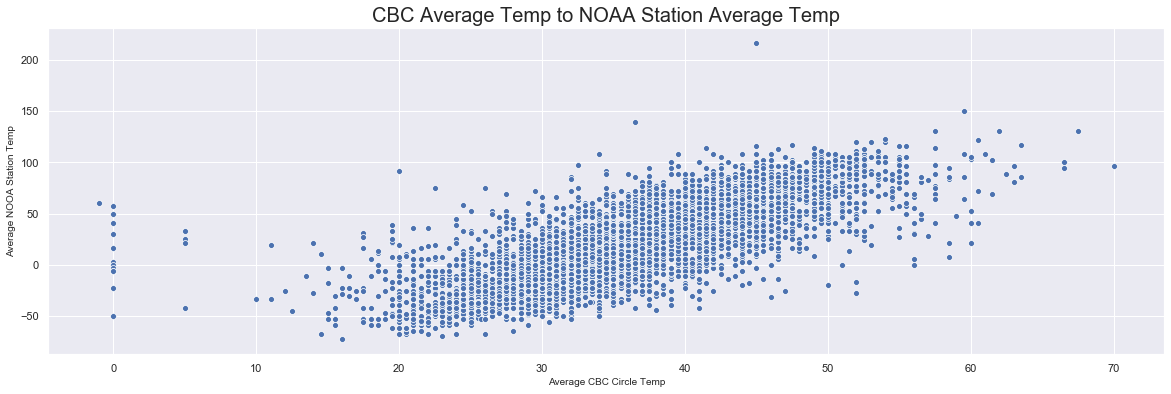

In [52]:
plt.figure(figsize=(20, 6))
sns.scatterplot(x=temp_df['circle_average_temp'], y=temp_df['noaa_average_temp'])
plt.title('CBC Average Temp to NOAA Station Average Temp', fontsize=20)
plt.xlabel('Average CBC Circle Temp', fontsize=10)
plt.ylabel('Average NOOA Station Temp', fontsize=10)
;

In [ ]:
temp_df.loc[temp_df['noaa_average']]

---
## Temperature Measurement Goodness with Interchangeable Metric

temp_metric = sqrt( (noaa_min_temp - circle_min_temp)^2 + (noaa_max_temp - circle_max_temp)^2 )

Going to compare two different metrics to get and idea of how varied they could be

### Metric 1
temp_metric_1 = sqrt( (noaa_min_temp - circle_min_temp)^2 + (noaa_max_temp - circle_max_temp)^2 )

In [ ]:
temp_df['temp_metric_1'] = round(np.sqrt(((temp_df['noaa_min_temp'] - temp_df['circle_min_temp'])**2) + ((temp_df['noaa_max_temp'] - temp_df['circle_max_temp'])**2)),2)

### Metric 2
temp_metric_2 = sqrt( (noaa_average - circle_average)^2 )

In [ ]:
temp_df['temp_metric_2'] = np.sqrt((temp_df['noaa_average'] - temp_df['circle_average'])**2)

In [ ]:
temp_df.sort_values(by=['temp_metric_1'])

### Catagories
Values in catagories can be changed and then applied to dataframe

In [ ]:
# Function to assign grade scores
def assign_grade(metric_score):
    if metric_score <= excellent:
        return 'excellent'
    elif metric_score <= good:
        return 'good'
    elif metric_score <= fair:
        return 'fair'
    else:
        return 'poor'

In [ ]:
# Applying the scores
temp_df['metric_grade'] = temp_df['temp_metric_1'].apply(lambda metric_score: assign_grade(metric_score))

In [ ]:
temp_df

---
## Plotting Circle Metric Scores by Lat/Lon

In [ ]:
plt.figure(figsize=(20, 6))
sns.scatterplot(x='circle_lat', y='circle_lon', data=temp_df, hue='metric_grade')
plt.title('Circle Locations by Metric Grade', fontsize=20)
plt.xlabel('Circle Lat', fontsize=10)
plt.ylabel('Circle Lon', fontsize=10)
;

In [ ]:
Next Steps
Clean Data
Plot time series using closest station